<a href="https://colab.research.google.com/github/DSAlexRS/python/blob/master/MLzoomcamp6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline

#preparing data

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv")

In [ ]:
select_cols = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
               "median_income", "median_house_value", "ocean_proximity"]

In [ ]:
df = df[select_cols]

In [ ]:
df.total_bedrooms = df.total_bedrooms.fillna(0)

In [ ]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [ ]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [ ]:
y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

In [ ]:
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']


#desicion tree

In [ ]:
train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [ ]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [ ]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [ ]:
y_pred = dt.predict(X_val)

In [ ]:
ms = mean_squared_error(y_val, y_pred)


In [ ]:
RMSE = np.sqrt(ms)
RMSE

0.46783724529735604

#Random Forest

In [ ]:
rf = RandomForestRegressor(n_estimators=10, random_state=1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=1)

In [ ]:
y_pred = rf.predict(X_val)

In [ ]:
ms = mean_squared_error(y_val, y_pred)
RMSE = np.sqrt(ms)
RMSE

0.24566012875324933

## tuning n_estimator

In [ ]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    ms = mean_squared_error(y_val, y_pred)
    RMSE = np.sqrt(ms)
    
    scores.append((n, RMSE))

In [ ]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'RMSE'])


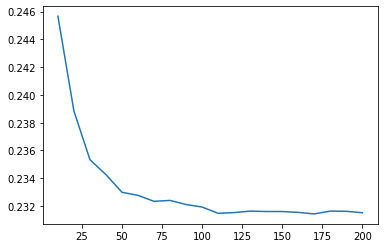

In [ ]:
plt.plot(df_scores.n_estimators, df_scores.RMSE)

In [ ]:
scores = []

for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        ms = mean_squared_error(y_val, y_pred)
        RMSE = np.sqrt(ms)

        scores.append((d, n, RMSE))

In [ ]:
columns = ['max_depth', 'n_estimators', 'RMSE']
df_scores = pd.DataFrame(scores, columns=columns)

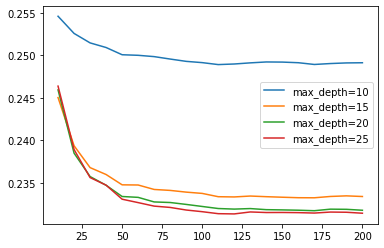

In [ ]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.RMSE,
             label='max_depth=%d' % d)

plt.legend()

In [ ]:
df_scores[df_scores["RMSE"] == min(df_scores["RMSE"])]

,max_depth,n_estimators,RMSE
71,25,120,0.231334


#feature importance information

In [ ]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
ms = mean_squared_error(y_val, y_pred)
RMSE = np.sqrt(ms)

In [ ]:
RMSE

0.23133444616905816

In [ ]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

In [ ]:
feature_names=dv.get_feature_names()

In [ ]:
feature_names[5] = 'ocean_proximity=1H OCEAN'

In [ ]:
feature_names

['households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity=1H OCEAN',
 'ocean_proximity=INLAND',
 'ocean_proximity=ISLAND',
 'ocean_proximity=NEAR BAY',
 'ocean_proximity=NEAR OCEAN',
 'population',
 'total_bedrooms',
 'total_rooms']

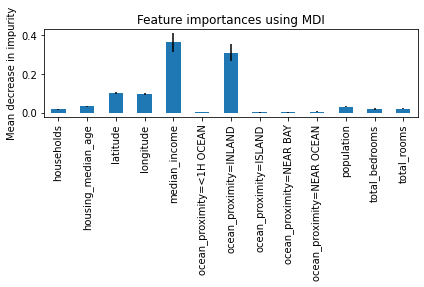

In [ ]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#XGBOOT

In [ ]:
features = dv.get_feature_names()
features[5] = 'ocean_proximity=1H OCEAN'
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [ ]:
y_pred = model.predict(dval)

In [ ]:
ms = mean_squared_error(y_val, y_pred)
RMSE = np.sqrt(ms)
RMSE

0.43233454290836426

In [ ]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [ ]:
y_pred = model.predict(dval)

In [ ]:
ms = mean_squared_error(y_val, y_pred)
RMSE = np.sqrt(ms)
RMSE

4.064611429441746

#aswers

Q1. ocean_proximity = INLAND 

Q2. 0.24566012875324933

Q3. at 50 the improvement start to become slower and it stops at 110.

Q4. the best max_depth is 25 but at 20 the results are very close. 

Q5. median_income and ocean_proximity = INLAND 

Q6  0.3 lead to better RMSE